# NbodyGradient

In [1]:
using NbodyGradient, Plots

### Initial Conditions
To get started, we need to setup initial conditions. This is done by specifying the orbital elements and masses. For `a`, the star, we only need the mass. For `b`, the planet, we need to tell the code where it is at a particular time. 

The orbital elements are as follows:
- P  : The orbital period of the body.
- t0 : The time that the body transits the star for the first time.
- ecos$\varpi$ : The eccentricity times the cosine of the longitude of periastron (the location the planet is closest to the star).
- I : The inclination of the orbit measured from the sky-plane (in other words, $\pi$/2 would allow us to see a transit)

Available parameters, but not specified here: 
- esin$\varpi$ (Needed if the pericenter is not along line of sight)
- $\Omega$: Longitude of ascending node (We usually assume 0.0)
- a : Orbital distance (in AU)
- e : Eccentricity (Not needed if ecos$\varpi$ and esin$\varpi$ are)
- $\varpi$ : Longitude of periastron (again, not needed here)

(**Note**: *the semi-major axis, a, and longitude of periastron, $\varpi$, are not calculated yet. That's ok for now!*)

In [2]:
a = Elements(m = 1.0) # Solar masses

b = Elements(
    m = 9e-4,       # Mass [Solar mass] 
    P = 4000.0,     # Period [Days]
    t0 = 0.0,       # Time of transit [Days]
    ecosϖ = 0.0001, # Eccentricity * cos(arg. of periastron)
    I = π / 2,      # Inclination [radians]
)

Elements{Float64}
a: 0.0
m: 0.0009
P: 4000.0
I: 1.5707963267948966
Ω: 0.0
e: 0.0001
t0: 0.0
ecosϖ: 0.0001
esinϖ: 0.0
ϖ: 0.0
Semi-major axis: undefined


Finally, we need the initial time (when to start the simulation), and the number of bodies.

In [3]:
t0 = 0.0 # Initial time of simulation [Days]
H = 2 # Number of bodies

ic = ElementsIC(t0, H, a, b) # Initial Conditions structure

ElementsIC{Float64}
Orbital Elements: 
2×7 Array{Float64,2}:
 1.0        0.0  0.0  0.0     0.0  0.0     0.0
 0.0009  4000.0  0.0  0.0001  0.0  1.5708  0.0

### Integrator

To setup the simulation, we need the time step, h, and the maximum time, tmax. Then we create an `Integrator`. This "type" also works like a function, which we will use to run the simulations.

h should be no larger than the shortest period divided by 20. (But it can be lower)

In [4]:
h = b.P / 40.0 # Time step [Days]
tmax = 100 * b.P

intr = Integrator(h, 0.0, tmax)

Integrator{Float64}(NbodyGradient.ah18!, 100.0, 0.0, 400000.0)

### Running simulations!

Last thing to do before running is to create a `State` -- the positions and velocities at a given time. 

In [5]:
s = State(ic) # Make sure everything is finite!

State{Float64}:
Positions  : finite
Velocities : finite
Jacobian   : finite


In [6]:
s.x # position vectors for each body (i.e. s.x[:,1] is the position vector for the first body)

3×2 Array{Float64,2}:
 4.69709e-19  -5.21899e-16
 2.71626e-19  -3.01807e-16
 0.00443599   -4.92888

Let's plot it to make sure we are starting out correctly. The orbit will be face-on in the x-z plane.

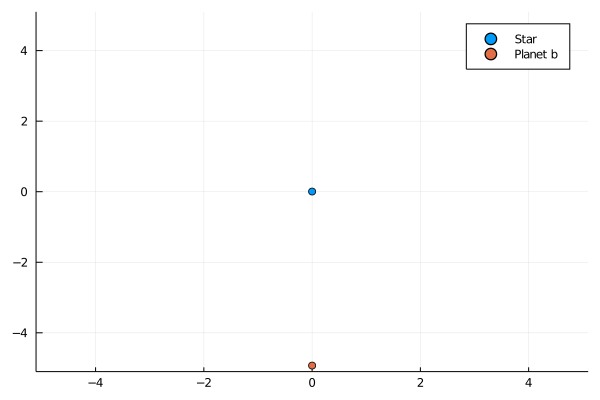

In [7]:
scatter([s.x[1,1]], [s.x[3,1]], label="Star")
scatter!([s.x[1,2]], [s.x[3,2]], label="Planet b")
xlims!(-5.1,5.1); ylims!(-5.1,5.1)

Now, to run the simulation, simply pass the `State` to the `Integrator`.

In [8]:
intr(s)

### Plotting orbits

So far we haven't output anything. Here we just save the `State` (positions and velocities) at each step in the integrator, using `CartesianOutput`. The arguments are: the type (this will be removed -- don't worry about it), the number of bodies, and the number of steps to save. 

In [9]:
s = State(ic) # Reset to initial conditions
o = CartesianOutput(Float64, 2, round(Int64,tmax / h)); # Records the State at each time step

In [10]:
intr(s,o) # Run the integrator again, and save outputs to `o`

In [11]:
## Here's a plotting function ##
# Don't worry too much about this.
# It just lets us plot orbits from the
# CartesianOutputs

@recipe function f(out::CartesianOutput; seriestype=:path)
    npts = length(out.states)
    N = out.states[1].n
    lm = maximum(abs.(out.states[1].x)) 
    lm += 0.5 * lm
    labels = ["a","b","c","d","e","f","g","h"]
    
    # Gather cartesian coordinates
    x = zeros(npts,N)
    y = zeros(npts,N)
    z = zeros(npts,N)
    for (i,o) in enumerate(out.states)
        x[i,:] = o.x[1,:]
        y[i,:] = o.x[2,:]
        z[i,:] = o.x[3,:]
    end
    
    # Setup subplots
    legend := :false
    grid := false
    xlims := (-lm,lm)
    ylims := (-lm,lm)
    layout := @layout [ 
        a{0.3h} 
        b{0.7h} 
    ]
    
    for i in 1:N
        @series begin
            seriestype := seriestype
            subplot := 1
            x[:,i],y[:,i]
        end
        @series begin
            seriestype := seriestype
            subplot := 2
            label := labels[i]
            legend := :best
            x[:,i],z[:,i]
        end
    end
end

Now, just pass `o` to the `plot` function and we'll see the orbits both face-on (x-z) and edge on (x-y). (You can change the size values to fit your screen)

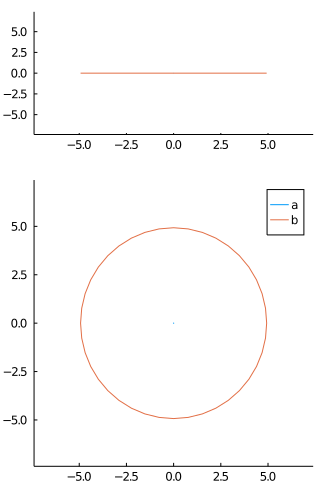

In [12]:
plot(o, size=(325,500))

### Adding planets

Now, try adding a planet. This can either be a known planet (with orbital elements you can look up) or see what happens when you change the orbital elements. I'll start you off with a skeleton below. Just fill in the values. (Do they all need to be specified? Does the order you place them in `ElementsIC` matter?)

In [ ]:
c = Elements(
    m = ,
    P = ,
    t0 = ,
    ecosϖ = ,
    esinϖ = ,
    I = ,
    Ω = 
)

ic = ElementsIC(0.0, 3, a, b, c)

Now, run the integrator with the new planet and plot the orbits. Remember to reset the the `State`, time step `h`, and `tmax`.